In [2]:
from typing import List
from MRL import FixedFeatureLayer, Matryoshka_CE_Loss, MRL_Linear_Layer
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [3]:
tensor_transform = transforms.ToTensor()
dataset = datasets.MNIST(
    root="./data", train=True, download=True, transform=tensor_transform
)
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=32, shuffle=True)

In [4]:
class MRL_Autoencoder(nn.Module):
    def __init__(self, nesting_list: List[int], num_classes: int, efficient=False):
        super(MRL_Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, nesting_list[-1]),
        )

        self.decoder = nn.Sequential(
            nn.Linear(nesting_list[-1], 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid(),
        )

        self.classifier = MRL_Linear_Layer(
            nesting_list=nesting_list,
            num_classes=num_classes,
            efficient=efficient,
        )

    def forward(self, x):
        z = self.encoder(x)                
        x_recon = self.decoder(z)         
        logits = self.classifier(z)      
        return x_recon, logits

## A bunch of variable

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("Using GPU")
model = MRL_Autoencoder(nesting_list=[9, 18, 36], num_classes=10).to(device)
recon_loss_fn = nn.MSELoss()
epochs = 20
outputs = []
losses = []
clf_loss_fn = Matryoshka_CE_Loss(relative_importance=[0.2, 0.3, 0.5])
optimizer = optim.Adam(model.parameters(), lr=1e-3)


Using GPU


In [8]:
for epoch in range(epochs):
    for images, labels in loader:
        images = images.view(-1, 28 * 28).to(device)
        labels = labels.to(device)

        recon, logits = model(images)

        # Compute losses
        recon_loss = recon_loss_fn(recon, images)
        clf_loss = clf_loss_fn(logits, labels)

        total_loss = recon_loss + clf_loss 
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        losses.append(total_loss.item())

    print(f"Epoch {epoch+1}/{epochs}, Recon Loss: {recon_loss.item():.4f}, Clf Loss: {clf_loss.item():.4f}")

Epoch 1/20, Recon Loss: 0.0163, Clf Loss: 0.0254
Epoch 2/20, Recon Loss: 0.0157, Clf Loss: 0.0314
Epoch 3/20, Recon Loss: 0.0189, Clf Loss: 0.0001
Epoch 4/20, Recon Loss: 0.0170, Clf Loss: 0.0000
Epoch 5/20, Recon Loss: 0.0187, Clf Loss: 0.0001
Epoch 6/20, Recon Loss: 0.0156, Clf Loss: 0.3105
Epoch 7/20, Recon Loss: 0.0140, Clf Loss: 0.1689
Epoch 8/20, Recon Loss: 0.0181, Clf Loss: 0.0040
Epoch 9/20, Recon Loss: 0.0149, Clf Loss: 0.0000
Epoch 10/20, Recon Loss: 0.0164, Clf Loss: 0.0004
Epoch 11/20, Recon Loss: 0.0182, Clf Loss: 0.1089
Epoch 12/20, Recon Loss: 0.0180, Clf Loss: 0.0000
Epoch 13/20, Recon Loss: 0.0169, Clf Loss: 0.0096
Epoch 14/20, Recon Loss: 0.0178, Clf Loss: 0.0060
Epoch 15/20, Recon Loss: 0.0154, Clf Loss: 0.0023
Epoch 16/20, Recon Loss: 0.0149, Clf Loss: 0.0015
Epoch 17/20, Recon Loss: 0.0154, Clf Loss: 0.0000
Epoch 18/20, Recon Loss: 0.0158, Clf Loss: 0.0001
Epoch 19/20, Recon Loss: 0.0135, Clf Loss: 0.0014
Epoch 20/20, Recon Loss: 0.0147, Clf Loss: 0.0001


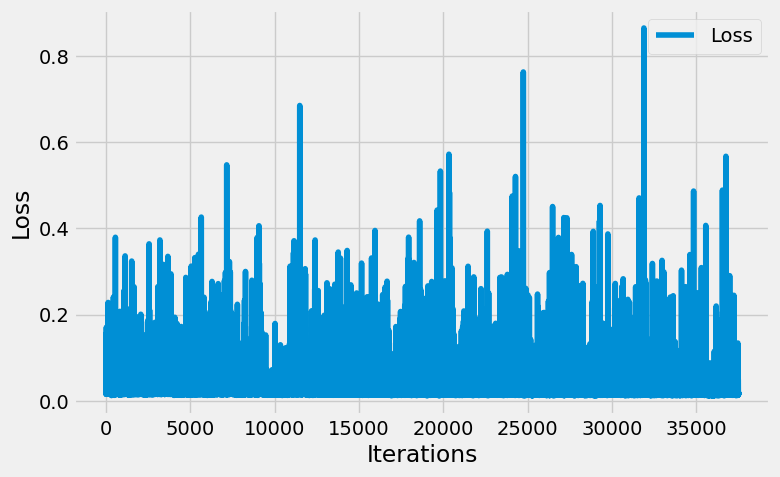

In [9]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 5))
plt.plot(losses, label="Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()

In [10]:
torch.save(model.state_dict(), "output/mrl_autoencoder_weights.pth")
torch.save(model, "output/mrl_autoencoder_model.pth")
print("Saved")

Saved
